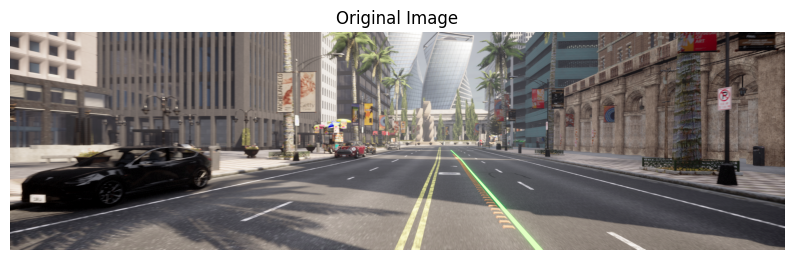

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = "00815602.png"  #
original = cv2.imread(image_path)
original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,6))
plt.imshow(original_rgb)
plt.title("Original Image")
plt.axis('off')
plt.show()

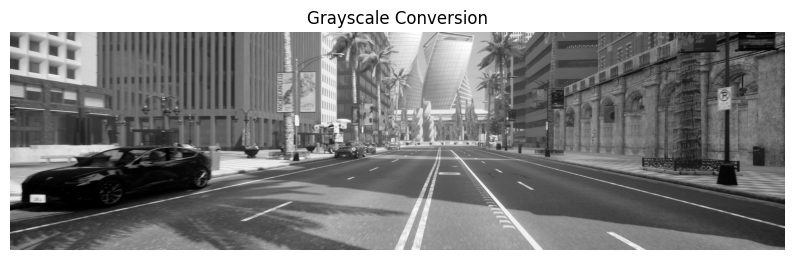

In [9]:
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10,6))
plt.imshow(gray, cmap='gray')
plt.title("Grayscale Conversion")
plt.axis('off')
plt.show()

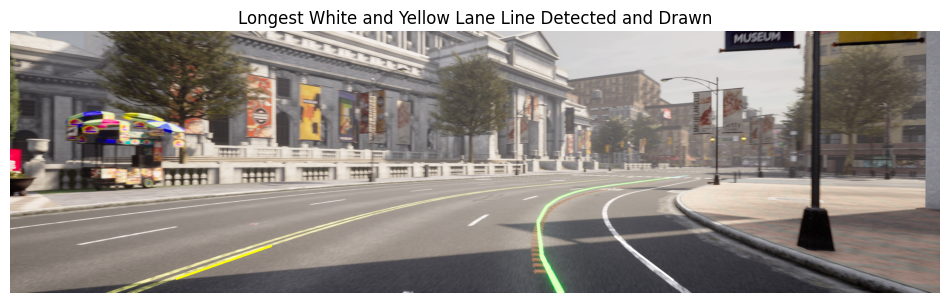

In [20]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

# Reload the image due to state reset
image_path = "filtered_centered/00815889.png"
original = cv2.imread(image_path)
hsv = cv2.cvtColor(original, cv2.COLOR_BGR2HSV)
height, width = original.shape[:2]

# Define HSV ranges
GREEN_LOWER = np.array([30, 20, 40])   # Allow lower saturation + broader hue start
GREEN_UPPER = np.array([100, 255, 255]) # Expand toward cyan/light blue

YELLOW_LOWER = np.array([15, 40, 40])
YELLOW_UPPER = np.array([40, 255, 255])

WHITE_LOWER = np.array([0, 0, 200])
WHITE_UPPER = np.array([180, 30, 255])

# Create masks
green_mask = cv2.inRange(hsv, GREEN_LOWER, GREEN_UPPER)
yellow_mask = cv2.inRange(hsv, YELLOW_LOWER, YELLOW_UPPER)
white_mask = cv2.inRange(hsv, WHITE_LOWER, WHITE_UPPER)

# ROI polygon
vertices = np.array([[  
    (int(width * 0.1), int(height * 0.95)),
    (int(width * 0.45), int(height * 0.7)),
    (int(width * 0.55), int(height * 0.7)),
    (int(width * 0.9), int(height * 0.95))
]], dtype=np.int32)
roi_mask = np.zeros_like(green_mask)
cv2.fillPoly(roi_mask, vertices, 255)

# Apply ROI
yellow_roi = cv2.bitwise_and(yellow_mask, roi_mask)
white_roi = cv2.bitwise_and(white_mask, roi_mask)

# Edge detection
yellow_edges = cv2.Canny(yellow_roi, 50, 150)
white_edges = cv2.Canny(white_roi, 50, 150)

# Hough line detection
yellow_lines = cv2.HoughLinesP(yellow_edges, 1, np.pi/180, 50, minLineLength=40, maxLineGap=50)
white_lines = cv2.HoughLinesP(white_edges, 1, np.pi/180, 50, minLineLength=40, maxLineGap=50)

# Draw only the longest yellow and longest white line
output = original.copy()

def draw_longest_line(lines, color):
    if lines is not None:
        max_len = 0
        best_line = None
        for line in lines:
            x1, y1, x2, y2 = line[0]
            length = np.sqrt((x2-x1)**2 + (y2-y1)**2)
            if length > max_len:
                max_len = length
                best_line = (x1, y1, x2, y2)
        if best_line is not None:
            cv2.line(output, best_line[:2], best_line[2:], color, 7)

draw_longest_line(yellow_lines, (0, 255, 255))  # Yellow, thick
draw_longest_line(white_lines, (255, 255, 255))  # White, thick

# Display
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("Longest White and Yellow Lane Line Detected and Drawn")
plt.axis('off')
plt.show()

## --------------------------------------------------

Randomly selected: 00861424.png
Detected angle: [-103.75795] degrees


C:\Users\Mohamed Abdo\AppData\Local\Temp\ipykernel_23344\433234892.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lefty = int((-x * vy / vx) + y)
C:\Users\Mohamed Abdo\AppData\Local\Temp\ipykernel_23344\433234892.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  righty = int(((vis_img.shape[1] - x) * vy / vx) + y)


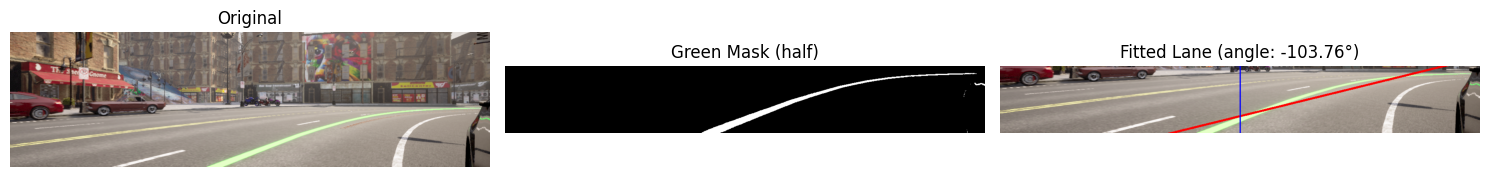

In [8]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt

def detect_green_lane_angle(image):
    h, w, _ = image.shape
    bottom_half = image[h//2:, :]
    hsv = cv2.cvtColor(bottom_half, cv2.COLOR_BGR2HSV)
    lower_green = np.array([40, 40, 40])
    upper_green = np.array([90, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, mask, bottom_half
    largest = max(contours, key=cv2.contourArea)
    [vx, vy, x, y] = cv2.fitLine(largest, cv2.DIST_L2, 0, 0.01, 0.01)
    angle = -np.degrees(np.arctan2(vx, vy))

    vis_img = bottom_half.copy()
    # Draw fitted lane
    lefty = int((-x * vy / vx) + y)
    righty = int(((vis_img.shape[1] - x) * vy / vx) + y)
    cv2.line(vis_img, (vis_img.shape[1] - 1, righty), (0, lefty), (0, 0, 255), 3)
    # Draw center vertical line
    center_x = vis_img.shape[1] // 2
    cv2.line(vis_img, (center_x, 0), (center_x, vis_img.shape[0]-1), (255, 0, 0), 2)
    return angle, mask, vis_img

if __name__ == "__main__":
    folder = 'filtered_centered'
    images = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not images:
        print("No images found.")
        exit()
    fname = random.choice(images)
    img = cv2.imread(os.path.join(folder, fname))
    if img is None:
        print(f"Failed to load {fname}")
        exit()
    angle, mask, vis_img = detect_green_lane_angle(img)
    print(f"Randomly selected: {fname}")
    print(f"Detected angle: {angle if angle is not None else 'None'} degrees")

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(mask, cmap='gray')
    plt.title('Green Mask (half)')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    if angle is not None:
        angle_val = angle.item() if hasattr(angle, 'item') else float(angle)
        plt.title(f'Fitted Lane (angle: {angle_val:.2f}°)')
    else:
        plt.title('Fitted Lane')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

C:\Users\Mohamed Abdo\AppData\Local\Temp\ipykernel_23344\3694471098.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lefty = int((-x * vy / vx) + y)
C:\Users\Mohamed Abdo\AppData\Local\Temp\ipykernel_23344\3694471098.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  righty = int(((vis_img.shape[1] - x) * vy / vx) + y)
C:\Users\Mohamed Abdo\AppData\Local\Temp\ipykernel_23344\3694471098.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lefty = int((-x * vy 

Randomly selected: 00825253.png
Detected lane center: 1172, image center: 1920
SVM predicted class: -1  (Left:-1, Straight:0, Right:1)


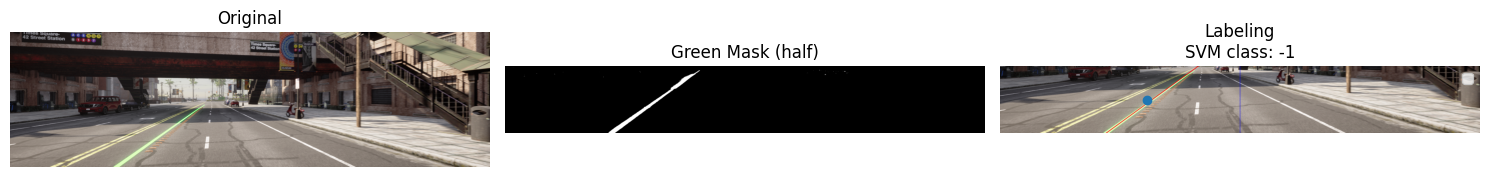

In [ ]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from sklearn import svm

def detect_green_lane_angle_and_center(image):
    h, w, _ = image.shape
    bottom_half = image[h//2:, :]
    hsv = cv2.cvtColor(bottom_half, cv2.COLOR_BGR2HSV)
    lower_green = np.array([40, 40, 40])
    upper_green = np.array([90, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, mask, bottom_half, None
    largest = max(contours, key=cv2.contourArea)
    [vx, vy, x, y] = cv2.fitLine(largest, cv2.DIST_L2, 0, 0.01, 0.01)
    angle = -np.degrees(np.arctan2(vx, vy))

    vis_img = bottom_half.copy()
    lefty = int((-x * vy / vx) + y)
    righty = int(((vis_img.shape[1] - x) * vy / vx) + y)
    cv2.line(vis_img, (vis_img.shape[1] - 1, righty), (0, lefty), (0, 0, 255), 3)
    # Draw center vertical blue line
    center_x = vis_img.shape[1] // 2
    cv2.line(vis_img, (center_x, 0), (center_x, vis_img.shape[0]-1), (255, 0, 0), 2)
    # Find green lane center (mean x of green pixels)
    green_coords = np.column_stack(np.where(mask > 0))
    if green_coords.size == 0:
        lane_center = None
    else:
        # green_coords[:,1] is the x axis
        lane_center = int(np.mean(green_coords[:,1]))
    return angle, mask, vis_img, lane_center

def classify_lane_position(lane_center, img_width):
    if lane_center is None:
        return 0  # default to straight if not found
    center_x = img_width // 2
    if lane_center < center_x - 10:  # 10 px margin
        return -1  # left
    elif lane_center > center_x + 10:
        return 1   # right
    else:
        return 0   # straight
# float:  to the max array , try , ideas for how many lefts, speed, 0.3 , paraments to addapt , 
if __name__ == "__main__":
    folder = 'filtered_centered'
    images = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not images:
        print("No images found.")
        exit()

    # Build dataset for SVM (X: lane_center offset, y: class)
    X = []
    y = []
    for fname in images[:50]:
        img = cv2.imread(os.path.join(folder, fname))
        if img is None:
            continue
        angle, mask, vis_img, lane_center = detect_green_lane_angle_and_center(img)
        img_width = vis_img.shape[1]
        label = classify_lane_position(lane_center, img_width)
        if lane_center is not None:
            X.append([lane_center - img_width//2])
            y.append(label)

    # Train SVM for 3 classes
    if len(set(y)) < 2:
        print("Not enough classes for SVM training. Try more varied images.")
        exit()
    clf = svm.SVC(kernel='linear')
    clf.fit(X, y)

    # Test on a random image from the dataset
    fname = random.choice(images)
    img = cv2.imread(os.path.join(folder, fname))
    angle, mask, vis_img, lane_center = detect_green_lane_angle_and_center(img)
    center_x = vis_img.shape[1] // 2
    predicted_class = clf.predict([[lane_center - center_x]])[0] if lane_center is not None else 0
    print(f"Randomly selected: {fname}")
    print(f"Detected lane center: {lane_center}, image center: {center_x}")
    print(f"SVM predicted class: {predicted_class}  (Left:-1, Straight:0, Right:1)")

    # Visualization
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(mask, cmap='gray')
    plt.title('Green Mask (half)')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    if lane_center is not None:
        plt.scatter([lane_center], [vis_img.shape[0]//2])
        plt.legend()
    plt.title(f'Labeling\nSVM class: {predicted_class}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split

def detect_green_lane_angle_and_center(image):
    h, w, _ = image.shape
    bottom_half = image[h//2:, :]
    hsv = cv2.cvtColor(bottom_half, cv2.COLOR_BGR2HSV)
    lower_green = np.array([40, 40, 40])
    upper_green = np.array([90, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None, None
    # Find the largest contour and fit a line to it
    largest = max(contours, key=cv2.contourArea)
    [vx, vy, x, y] = cv2.fitLine(largest, cv2.DIST_L2, 0, 0.01, 0.01)
    angle = -np.degrees(np.arctan2(vx, vy))
    green_coords = np.column_stack(np.where(mask > 0))
    if green_coords.size == 0:
        lane_center = None
    else:
        lane_center = int(np.mean(green_coords[:, 1]))
    img_width = bottom_half.shape[1]
    return angle, lane_center, img_width

def classify_lane_position(lane_center, img_width):  # Classify lane position
    if lane_center is None:
        return 0
    center_x = img_width // 2
    if lane_center < center_x - 10:
        return -1
    elif lane_center > center_x + 10:
        return 1
    else:
        return 0
'#### latency, '
# Process dataset
folder = 'filtered_centered'
images = [f for f in os.listdir(folder) if f.lower().endswith('.png')]
images.sort()

data = []
for fname in images:
    img = cv2.imread(os.path.join(folder, fname))
    if img is None:
        continue
    angle, lane_center, img_width = detect_green_lane_angle_and_center(img)
    label = classify_lane_position(lane_center, img_width) if (lane_center is not None and img_width is not None) else 0
    if angle is not None:
        data.append({'frame': fname, 'slope': float(angle), 'label': label})  # Fixed key here

# DataFrame
df = pd.DataFrame(data)[['frame', 'slope', 'label']]

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
train_df.to_csv('lane_svm_train.csv', index=False, sep=';', quoting=0)
test_df.to_csv('lane_svm_test.csv', index=False, sep=';', quoting=0)

print(f"Train and test CSVs saved with columns: frame;slope;label")
print("Train set sample:\n", train_df.head())
print("Test set sample:\n", test_df.head())


C:\Users\Mohamed Abdo\AppData\Local\Temp\ipykernel_21308\4121507959.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data.append({'frame': fname, 'slope': float(angle), 'label': label})  # Fixed key here


Train and test CSVs saved with columns: frame;slope;label
Train set sample:
             frame       slope  label
595  00859189.png -148.543777     -1
131  00825763.png  -98.927284     -1
44   00818519.png -154.620331     -1
70   00820003.png -148.407333     -1
672  00865863.png -157.834641      1
Test set sample:
             frame       slope  label
506  00853363.png  -66.145294      1
357  00842650.png  -43.724495      1
133  00825876.png  -94.855766      1
250  00835410.png -144.562149     -1
299  00838580.png -100.834541      1


=== Linear SVM ===
              precision    recall  f1-score   support

          -1       0.66      0.63      0.64        76
           0       0.00      0.00      0.00         2
           1       0.62      0.67      0.64        72

    accuracy                           0.64       150
   macro avg       0.43      0.43      0.43       150
weighted avg       0.63      0.64      0.64       150

Accuracy: 64.00%

=== RBF SVM ===
              precision    recall  f1-score   support

          -1       0.76      0.34      0.47        76
           0       0.00      0.00      0.00         2
           1       0.64      0.79      0.71        72

    accuracy                           0.55       150
   macro avg       0.47      0.38      0.39       150
weighted avg       0.69      0.55      0.58       150

Accuracy: 55.33%

=== Random Forest ===
              precision    recall  f1-score   support

          -1       0.62      0.64      0.63        76
           0       0.00      0.00   

c:\Users\Mohamed Abdo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Mohamed Abdo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Mohamed Abdo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

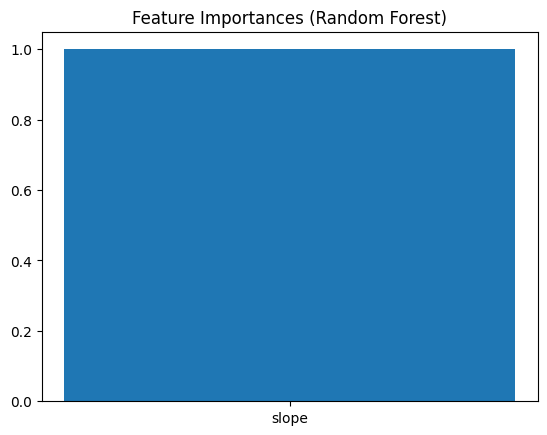

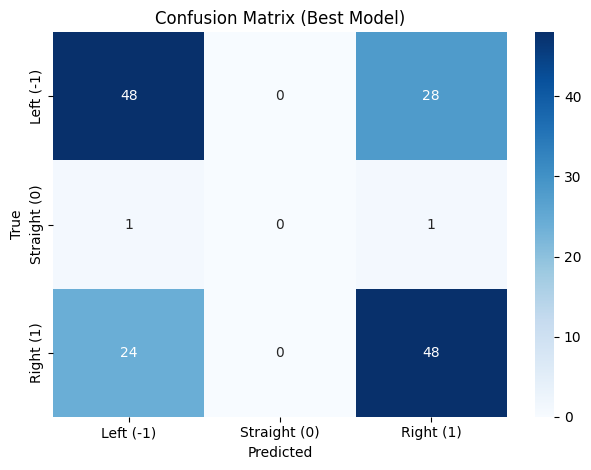

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# --- Load data ---
train_df = pd.read_csv('lane_svm_train.csv', sep=',')
test_df = pd.read_csv('lane_svm_test.csv', sep=',')

# Fix columns if not split
if train_df.shape[1] == 1:
    train_df = train_df.iloc[:,0].str.split(';', expand=True)
    train_df.columns = ['frame', 'slope', 'offset', 'green_pixels', 'label']
    train_df['slope'] = train_df['slope'].astype(float)
    train_df['offset'] = train_df['offset'].astype(float)
    train_df['green_pixels'] = train_df['green_pixels'].astype(float)
    train_df['label'] = train_df['label'].astype(int)
if test_df.shape[1] == 1:
    test_df = test_df.iloc[:,0].str.split(';', expand=True)
    test_df.columns = ['frame', 'slope', 'offset', 'green_pixels', 'label']
    test_df['slope'] = test_df['slope'].astype(float)
    test_df['offset'] = test_df['offset'].astype(float)
    test_df['green_pixels'] = test_df['green_pixels'].astype(float)
    test_df['label'] = test_df['label'].astype(int)

# --- Remove outliers ---
for col in ['slope']:
    mean = train_df[col].mean()
    std = train_df[col].std()
    train_df = train_df[(train_df[col] > mean - 3 * std) & (train_df[col] < mean + 3 * std)]

# --- Prepare feature matrix ---
feature_cols = ['slope']  # Only use columns that exist in the DataFrame
X_train = train_df[feature_cols].values
y_train = train_df['label'].values
X_test = test_df[feature_cols].values
y_test = test_df['label'].values

# --- Try Linear SVM ---
clf_linear = make_pipeline(StandardScaler(), svm.SVC(kernel='linear', class_weight='balanced'))
clf_linear.fit(X_train, y_train)
y_pred_linear = clf_linear.predict(X_test)
acc_linear = accuracy_score(y_test, y_pred_linear)
print("=== Linear SVM ===")
print(classification_report(y_test, y_pred_linear))
print(f"Accuracy: {acc_linear:.2%}\n")

# --- Try RBF SVM ---
clf_rbf = make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', class_weight='balanced'))
clf_rbf.fit(X_train, y_train)
y_pred_rbf = clf_rbf.predict(X_test)
acc_rbf = accuracy_score(y_test, y_pred_rbf)
print("=== RBF SVM ===")
print(classification_report(y_test, y_pred_rbf))
print(f"Accuracy: {acc_rbf:.2%}\n")

# --- Try Random Forest ---
clf_rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print(f"Accuracy: {acc_rf:.2%}\n")

# --- Feature Importance (Random Forest) ---
importances = clf_rf.feature_importances_
plt.bar(feature_cols, importances)
plt.title('Feature Importances (Random Forest)')
plt.show()

# --- Confusion Matrix (best model) ---
best_pred = y_pred_rf if acc_rf >= max(acc_linear, acc_rbf) else (y_pred_linear if acc_linear >= acc_rbf else y_pred_rbf)
confmat = confusion_matrix(y_test, best_pred, labels=[-1, 0, 1])
sns.heatmap(confmat, annot=True, fmt='d', cmap="Blues",
            xticklabels=['Left (-1)', 'Straight (0)', 'Right (1)'],
            yticklabels=['Left (-1)', 'Straight (0)', 'Right (1)'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Best Model)')
plt.tight_layout()
plt.show()